
"""

Performance Variables 

- Wins 
- Places
- Win as Favs 
- Place as Favs
- Wins as Underdogs
- Place as Underdogs

"""


# Import the code 


In [1]:

#fileloc  = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one/code/Users/karan.bhatti'
fileloc  = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one-8c-32gb/code/Users/karan.bhatti/Dataprep'

import sys
print(sys.path)
print()

#sys.path.append(f'{fileloc}')

print()
#print(sys.path)


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-one-8c-32gb/code/Users/karan.bhatti/Code', '/anaconda/envs/azureml_py38/lib/python38.zip', '/anaconda/envs/azureml_py38/lib/python3.8', '/anaconda/envs/azureml_py38/lib/python3.8/lib-dynload', '', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/azureml/_project/vendor', '/anaconda/envs/azureml_py38/lib/python3.8/site-packages/azureml/automl/core/_vendor']




In [2]:

class Data(object):
    pass

df = Data
summ = Data


In [3]:
import helpdesk as hd

In [15]:

import pandas as pd, numpy as np
from datetime import datetime
import pytz

# Get the current UTC time
utc_now = datetime.now(pytz.utc)

# Convert it to local time
#local_tz = pytz.timezone('America/Los_Angeles')  # Replace with your timezone
local_tz = pytz.timezone('Asia/Kolkata')  # Set timezone to India (IST)


In [5]:
DEBUG = True

In [6]:

pd.set_option('display.max_rows', 50);
pd.set_option('display.max_columns', 50);
pd.set_option('display.width', 200);


In [7]:


df.ft_raw = pd.read_csv(f'{fileloc}/raw_base_2023-06-05.csv', parse_dates = True)

print(df.ft_raw.shape)
print(df.ft_raw.columns.values.tolist())



(725080, 33)
['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos']


In [8]:

print(pd.DataFrame(df.ft_raw.position.value_counts()).transpose())

print(pd.DataFrame(df.ft_raw.x_num_dogs.value_counts()).transpose())


               1       2       3       4       5      6      7      8
position  100612  100492  100451  100408  100364  93823  75966  52964
                 8       7       6      5
x_num_dogs  424192  161259  106944  32685


### B) Create Variable for Performance

In [9]:

df_base_perf = df.ft_raw.copy()


In [10]:

# Sort for Easy QC
df_base_perf.sort_values(by = ['@id_DOG', 'DogName', 'Event_Dt'], inplace = True)


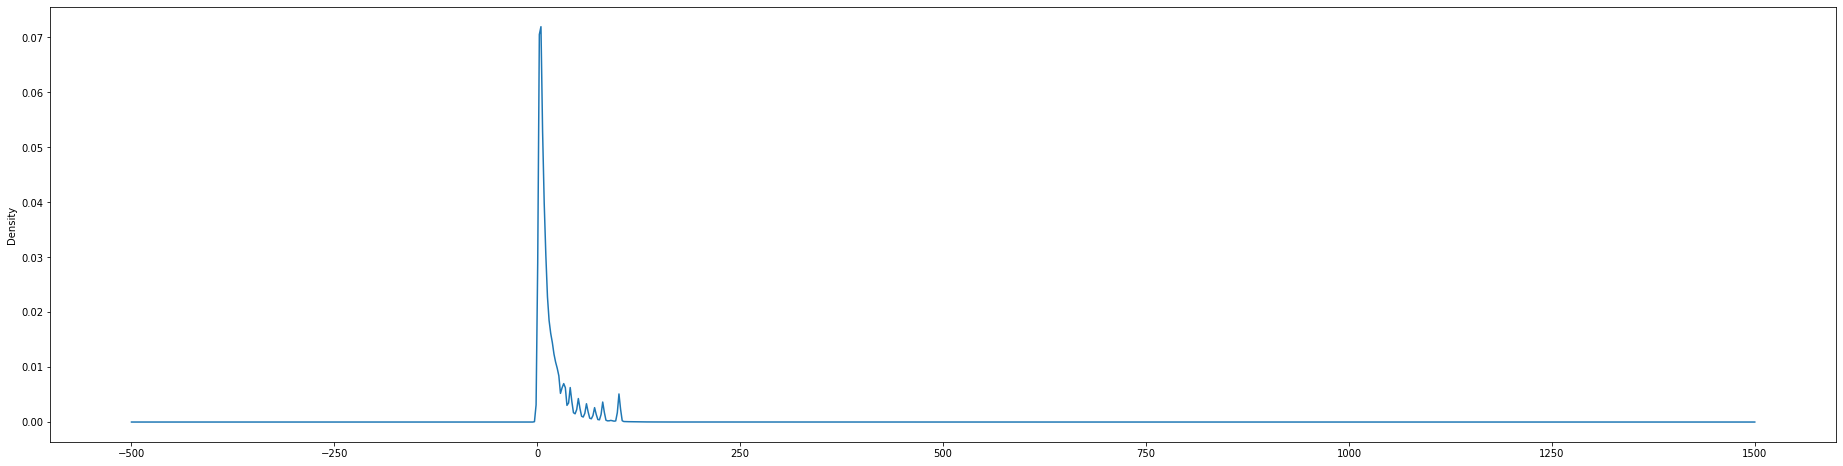

In [11]:

df_base_perf['ft_sp'].plot(kind = 'density', figsize= (32,8) )


In [12]:

# Ranks based on the Fast Track sp
groupings = ['@id_RACE']

# For groupby doglevel
doglevel = ['@id_DOG']


## Rank for Place Preds
print(datetime.now())
df_base_perf["position_fasttrack"] = df_base_perf.groupby(groupings)["ft_sp"].rank("dense", ascending=True)
print(datetime.now())


2023-06-08 11:32:40.141337
2023-06-08 11:32:40.340093


##### Wins related Performance 

In [23]:

print(df_base_perf['position'].dtypes)
print(df_base_perf['position'].value_counts())


int64
1    100612
2    100492
3    100451
4    100408
5    100364
6     93823
7     75966
8     52964
Name: position, dtype: int64


In [18]:

# Total Races
df_base_perf.loc[:,"xr_races"] = df_base_perf.groupby(doglevel).cumcount()

# Total Races in last 5 
#df_base_perf.loc[:,"xr_races_l5"] = df_base_perf.groupby(doglevel).rolling(5, min_periods=1)['xr_races'].count().reset_index(0,drop=True)
df_base_perf['xr_races_l5'] = df_base_perf.groupby(doglevel).rolling(5, min_periods=1)['xr_races'].count().reset_index(0, drop=True)



#Wins by a Dog
#df_base_perf.loc[:,"wins"] = df_base_perf['position'].apply(lambda x : 1 if x == '1' else 0 )
df_base_perf['wins'] = df_base_perf['position'].eq(1).astype(int) #vectorised way



# Rolling wins for each Dog
#df_base_perf.loc[:,"wins_prev"] = df_base_perf.groupby(doglevel)['wins'].shift(1)
df_base_perf['wins_prev'] = df_base_perf.groupby(doglevel)['wins'].shift(1)

#df_base_perf.loc[:,"xr_wins"] = df_base_perf.groupby(doglevel)['wins_prev'].rolling(window=999, min_periods = 1).sum().reset_index(0,drop=True)
#df_base_perf['xr_wins'].fillna(0, inplace = True)
df_base_perf['xr_wins'] = df_base_perf.groupby(doglevel)['wins_prev']\
                            .rolling(window=999, min_periods=1)\
                            .sum()\
                            .reset_index(0, drop=True)\
                            .fillna(0)

#df_base_perf.loc[:,"xr_wins_pct"] = df_base_perf['xr_wins'] / df_base_perf['xr_races']
df_base_perf['xr_wins_pct'] = df_base_perf['xr_wins'] / df_base_perf['xr_races']
df_base_perf['xr_wins_pct'].fillna(0, inplace = True)


## Wins in the Last 5 Races
#df_base_perf.loc[:,"xr_wins_l5"] = df_base_perf.groupby(doglevel)['wins_prev'].rolling(window=5, min_periods = 1).sum().reset_index(0,drop=True)
#df_base_perf['xr_wins_l5'].fillna(0, inplace = True)
df_base_perf["xr_wins_l5"] = df_base_perf.groupby(doglevel)['wins_prev']\
                                .rolling(window=5, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)


#df_base_perf.loc[:,"xr_wins_l5_pct"] = df_base_perf['xr_wins_l5'] / df_base_perf['xr_races_l5']
df_base_perf["xr_wins_l5_pct"] = df_base_perf['xr_wins_l5'] / df_base_perf['xr_races_l5']

print(datetime.now())

#.rolling(8, min_periods=1, on='Date')['Sold'].sum().reset_index()['Sold']


2023-06-08 11:36:35.879209


In [19]:

# Filter column names
stats_columns = df_base_perf.columns

# Apply describe to the filtered columns
stats_desc = df_base_perf[stats_columns].describe()

print(df_base_perf.shape)
print()

# Display the result
display(stats_desc)


(725080, 42)



,@id_DOG,Box,Rug,Weight,Handicap,Margin1,Margin2,Checks,SplitMargin,y_runtime,Prizemoney,RaceId,TrainerId,@id_RACE,RaceNum,ft_sp,x_num_dogs,position,y_margin,y_pos,position_fasttrack,xr_races,xr_races_l5,wins,wins_prev,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct
count,7.250800e+05,725080.000000,725080.000000,725079.000000,0.0,725080.000000,624468.000000,725080.000000,605308.000000,725080.000000,498861.000000,7.250800e+05,725080.000000,7.250800e+05,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,694567.000000,725080.000000,725080.000000,725080.000000,725080.000000
mean,4.866356e+08,4.477743,4.584582,29.935174,NaN,6.483733,2.071076,0.426676,7.265410,24.363969,441.621810,7.640069e+08,111702.449377,7.640069e+08,6.173288,17.092809,7.347380,4.171696,6.396170,4.171696,4.033828,20.092517,4.598293,0.138760,0.141629,3.056668,0.153317,0.637501,0.131923
std,1.219313e+08,2.343451,2.431397,3.312836,NaN,8.260129,7.241565,1.439907,2.526565,4.941794,2912.322446,7.786416e+07,78747.029834,7.786416e+07,3.287968,21.284010,0.890034,2.163317,4.794569,2.163317,2.090421,17.819576,1.030498,0.345696,0.348670,3.530232,0.160202,0.848094,0.174904
min,1.083910e+08,1.000000,1.000000,18.700000,NaN,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,6.238619e+08,6418.000000,6.238619e+08,1.000000,0.260000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.159944e+08,2.000000,2.000000,27.200000,NaN,2.530000,0.570000,0.000000,5.500000,20.520000,0.000000,6.985139e+08,65438.000000,6.985139e+08,3.000000,4.200000,7.000000,2.000000,2.530000,2.000000,2.000000,6.000000,5.000000,0.000000,0.000000,1.000000,0.016667,0.000000,0.000000
50%,4.791464e+08,4.000000,4.000000,29.900000,NaN,5.500000,1.410000,0.000000,6.780000,23.490000,65.000000,7.654781e+08,99808.000000,7.654781e+08,6.000000,8.700000,8.000000,4.000000,5.500000,4.000000,4.000000,15.000000,5.000000,0.000000,0.000000,2.000000,0.125000,0.000000,0.000000
75%,5.620734e+08,7.000000,7.000000,32.500000,NaN,9.140000,2.700000,0.000000,8.750000,26.990000,425.000000,8.292900e+08,125087.000000,8.292900e+08,9.000000,21.000000,8.000000,6.000000,9.140000,6.000000,6.000000,29.000000,5.000000,0.000000,0.000000,4.000000,0.222222,1.000000,0.200000
max,2.145360e+09,8.000000,10.000000,55.000000,NaN,5229.500000,5100.140000,25.000000,30.660000,396.120000,1000000.000000,8.978632e+08,337600.000000,8.978632e+08,20.000000,999.990000,8.000000,8.000000,27.000000,8.000000,8.000000,147.000000,5.000000,1.000000,1.000000,41.000000,1.000000,5.000000,1.000000


In [20]:

#df_base_perf[ df_base_perf['@id_DOG'].isin( [109766097, 113531628] ) ].head(45)
df_base_perf[135:145]


,@id_DOG,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,y_runtime,Prizemoney,RaceId,TrainerId,TrainerName,@id_RACE,RaceNum,RaceName,RaceTime,Distance,RaceGrade,Track,date,Event_Dt,ft_sp,x_num_dogs,position,y_margin,y_pos,position_fasttrack,xr_races,xr_races_l5,wins,wins_prev,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct
135,115152021,4,KING JEREMY,6.0,6,38.3,$21.00,NaN,4.25,1.29,NaN,0,NaN,4.56,17.23,0.0,638811645,289547,T Bradley,638811645,6,RURAL CITY OF MURRAY BRIDGE STAKE,01:09PM,300m,Grade 5,Murray Bridge,09 Feb 21,2021-02-09,21.0,7,4,4.25,4,6.0,2,3.0,0,0.0,0.0,0.0,0.0,0.0
136,115152021,2,KING JEREMY,2.0,2,38.0,$4.80,NaN,1.75,1.71,NaN,0,NaN,4.54,16.95,160.0,640881752,289547,T Bradley,640881752,3,METRO ROLLER DOORS (5+ WINS N/P) STAKE,12:15PM,300m,Special Event Non Penalty,Murray Bridge,16 Feb 21,2021-02-16,4.8,5,2,1.75,2,3.0,3,4.0,0,0.0,0.0,0.0,0.0,0.0
137,115152021,6,KING JEREMY,2.0,2,37.3,$101.00,NaN,4.25,0.14,6,0,NaN,4.59,17.11,0.0,645453386,289547,T Bradley,645453386,7,METRO ROLLER DOORS,01:44PM,300m,Grade 5 Heat,Murray Bridge,02 Mar 21,2021-03-02,101.0,8,6,4.25,6,7.0,4,5.0,0,0.0,0.0,0.0,0.0,0.0
138,115152021,4,KING JEREMY,7.0,7,37.7,$11.00,NaN,4.25,1.14,NaN,0,NaN,4.57,17.18,105.0,647734905,289547,T Bradley,647734905,10,SKY RACING (5+ WINS N/P) STAKE,02:55PM,300m,Special Event Non Penalty,Murray Bridge,09 Mar 21,2021-03-09,11.0,6,4,4.25,4,4.0,5,5.0,0,0.0,0.0,0.0,0.0,0.0
139,115152021,4,KING JEREMY,1.0,1,38.3,$34.00,NaN,1.75,0.00,NaN,0,NaN,4.49,17.01,0.0,650237621,289547,T Bradley,650237621,8,KURT DONSBERG PHOTOGRAPHY STAKE,02:07PM,300m,Grade 5,Murray Bridge,23 Mar 21,2021-03-23,34.0,8,4,1.75,4,6.0,6,5.0,0,0.0,0.0,0.0,0.0,0.0
140,115152021,4,KING JEREMY,5.0,5,37.5,$31.00,NaN,2.50,0.86,NaN,0,NaN,4.58,16.92,105.0,656343044,289547,T Bradley,656343044,4,METRO ROLLER DOORS (N/P) STAKE,09:10AM,300m,Restricted Win,Murray Bridge,17 Apr 21,2021-04-17,31.0,6,4,2.50,4,5.0,7,5.0,0,0.0,0.0,0.0,0.0,0.0
141,115152021,3,KING JEREMY,5.0,5,37.2,$21.00,NaN,2.00,0.14,NaN,0,NaN,4.61,16.99,130.0,663047537,289547,T Bradley,663047537,5,SKY RACING (N/P) STAKE,12:49PM,300m,Restricted Win,Murray Bridge,28 Apr 21,2021-04-28,21.0,8,3,2.00,3,6.0,8,5.0,0,0.0,0.0,0.0,0.0,0.0
142,115152021,3,KING JEREMY,4.0,4,36.8,$41.00,NaN,4.00,1.71,NaN,0,NaN,4.57,16.91,80.0,667670251,289547,T Bradley,667670251,5,TABCORP STAKE,01:02PM,300m,Grade 5,Murray Bridge,12 May 21,2021-05-12,41.0,5,3,4.00,3,4.0,9,5.0,0,0.0,0.0,0.0,0.0,0.0
143,115152021,2,KING JEREMY,8.0,8,37.0,$12.00,NaN,1.75,1.71,NaN,0,NaN,4.57,16.86,160.0,670592539,289547,T Bradley,670592539,10,SKY RACING STAKE,02:47PM,300m,Grade 5,Murray Bridge,19 May 21,2021-05-19,12.0,6,2,1.75,2,4.0,10,5.0,0,0.0,0.0,0.0,0.0,0.0
144,115152021,2,KING JEREMY,2.0,2,38.0,$7.00,NaN,1.00,1.00,NaN,0,NaN,4.50,16.83,160.0,672986829,289547,T Bradley,672986829,9,TABCORP STAKE,02:12PM,300m,Grade 5,Murray Bridge,26 May 21,2021-05-26,7.0,5,2,1.00,2,2.0,11,5.0,0,0.0,0.0,0.0,0.0,0.0


In [24]:

#Top 2 Finish

#df_base_perf.loc[:,"fin_t2"] = df_base_perf['position'].apply(lambda x : 1 if x in [1,2] else 0 )
df_base_perf['fin_t2'] = df_base_perf['position'].isin([1, 2]).astype(int)

# Rolling wins for each Dog
df_base_perf["fin_t2_prev"] = df_base_perf.groupby(doglevel)['fin_t2'].shift(1)
df_base_perf["xr_fin_t2"] = df_base_perf.groupby(doglevel)['fin_t2_prev']\
                                    .rolling(window=999, min_periods = 1)\
                                    .sum()\
                                    .reset_index(0,drop=True)\
                                    .fillna(0)

df_base_perf["xr_finl5_t2"] = df_base_perf.groupby(doglevel)['fin_t2_prev']\
                                    .rolling(window=5, min_periods = 1)\
                                    .sum()\
                                    .reset_index(0,drop=True)\
                                    .fillna(0, inplace = True)

df_base_perf["xr_fin_t2_pct"] = df_base_perf['xr_fin_t2'] / df_base_perf['xr_races']
df_base_perf['xr_fin_t2_pct'].fillna(0, inplace = True)

df_base_perf["xr_finl5_t2_pct"] = df_base_perf['xr_finl5_t2'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_t2_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-06-08 11:37:45.159968


In [25]:

print(df_base_perf.columns.values.tolist())


['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct']


##### Last position related performance

In [26]:

#Finish Last
#df_base_perf.loc[:,"fin_last"] = df_base_perf.apply(lambda x : 1 if x.position == x.x_num_dogs else 0 , axis = 1)
df_base_perf['fin_last'] = (df_base_perf['position'] == df_base_perf['x_num_dogs']).astype(int)

# Rolling wins for each Dog
df_base_perf["fin_last_prev"] = df_base_perf.groupby(doglevel)['fin_last'].shift(1)
df_base_perf["xr_fin_last"] = df_base_perf.groupby(doglevel)['fin_last_prev']\
                                .rolling(window=999, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)

df_base_perf["xr_fin_last_pct"] = df_base_perf['xr_fin_last'] / df_base_perf['xr_races']


df_base_perf["xr_finl5_last"] = df_base_perf.groupby(doglevel)['fin_last_prev']\
                                .rolling(window=5, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)

df_base_perf["xr_finl5_last_pct"] = df_base_perf['xr_finl5_last'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_last_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-06-08 11:38:06.075593


In [27]:

#Finish Last x 2
#df_base_perf.loc[:,"fin_last2"] = df_base_perf.apply(lambda x : 1 if (x.position == x.x_num_dogs) | (x.position == x.x_num_dogs - 1) else 0 , axis = 1)
df_base_perf['fin_last2'] = ((df_base_perf['position'] == df_base_perf['x_num_dogs']) | 
                             (df_base_perf['position'] == df_base_perf['x_num_dogs'] - 1)).astype(int)


# Rolling wins for each Dog
df_base_perf["fin_last2_prev"] = df_base_perf.groupby(doglevel)['fin_last2'].shift(1)
df_base_perf["xr_fin_last2"] = df_base_perf.groupby(doglevel)['fin_last2_prev']\
                                .rolling(window=999, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)

df_base_perf["xr_fin_last2_pct"] = df_base_perf['xr_fin_last2'] / df_base_perf['xr_races']
df_base_perf['xr_fin_last2_pct'].fillna(0, inplace = True)


df_base_perf["xr_finl5_last2"] = df_base_perf.groupby(doglevel)['fin_last2_prev']\
                                    .rolling(window=5, min_periods = 1)\
                                    .sum()\
                                    .reset_index(0,drop=True)\
                                    .fillna(0)

df_base_perf['xr_finl5_last2'].fillna(0, inplace = True)

df_base_perf["xr_finl5_last2_pct"] = df_base_perf['xr_finl5_last2'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_last2_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-06-08 11:38:27.011167


##### Place related performance

In [28]:

#Create a Placed variable 
    
# df_base_perf.loc[:,"fin_plc"] = df_base_perf.apply(lambda x : 1 if (x.position in [1,2,3]) & (x.x_num_dogs >=8)\
#                                     else 1 if (x.position in [1,2]) & (x.x_num_dogs >= 5)\
#                                     else 0 if (x.x_num_dogs < 5)\
#                                     else 0, axis = 1)

conditions = [
    ((df_base_perf['position'].isin([1,2,3])) & (df_base_perf['x_num_dogs'] >= 8)), 
    ((df_base_perf['position'].isin([1,2])) & (df_base_perf['x_num_dogs'] >= 5)), 
    (df_base_perf['x_num_dogs'] < 5)
]
choices = [1, 1, 0]

df_base_perf['fin_plc'] = np.select(conditions, choices, default=0)




# Rolling wins for each Dog
df_base_perf["fin_plc_prev"] = df_base_perf.groupby(doglevel)['fin_plc'].shift(1)

df_base_perf["xr_fin_plc"] = df_base_perf.groupby(doglevel)['fin_plc_prev']\
                                .rolling(window=999, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)

df_base_perf['xr_fin_plc'].fillna(0, inplace = True)

df_base_perf["xr_fin_plc_pct"] = df_base_perf['xr_fin_plc'] / df_base_perf['xr_races']
df_base_perf['xr_fin_plc_pct'].fillna(0, inplace = True)


df_base_perf["xr_finl5_plc"] = df_base_perf.groupby(doglevel)['fin_plc_prev']\
                                .rolling(window=5, min_periods = 1)\
                                .sum()\
                                .reset_index(0,drop=True)\
                                .fillna(0)

df_base_perf['xr_finl5_plc'].fillna(0, inplace = True)

df_base_perf["xr_finl5_plc_pct"] = df_base_perf['xr_finl5_plc'] / df_base_perf['xr_races_l5']
df_base_perf['xr_finl5_plc_pct'].fillna(0, inplace = True)

print(datetime.now())


2023-06-08 11:38:48.020645


In [29]:

print( pd.DataFrame(df_base_perf.isna().sum() ).transpose() )


   @id_DOG  Place  DogName  Box  Rug  Weight  StartPrice  Handicap  Margin1  Margin2    PIR  Checks  Comments  SplitMargin  y_runtime  Prizemoney  RaceId  TrainerId  TrainerName  @id_RACE  RaceNum  \
0        0      0        0    0    0       1           0    725080        0   100612  97952       0    351207       119772          0      226219       0          0            0         0        0   

   RaceName  RaceTime  Distance  RaceGrade  ...  xr_wins_l5_pct  fin_t2  fin_t2_prev  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  fin_last  fin_last_prev  xr_fin_last  xr_fin_last_pct  \
0        15         0         0          0  ...               0       0        30513          0       725080              0                0         0          30513            0            30513   

   xr_finl5_last  xr_finl5_last_pct  fin_last2  fin_last2_prev  xr_fin_last2  xr_fin_last2_pct  xr_finl5_last2  xr_finl5_last2_pct  fin_plc  fin_plc_prev  xr_fin_plc  xr_fin_plc_pct  xr_finl5_plc  \
0

In [30]:

df_base_perf[25:30]


,@id_DOG,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,y_runtime,Prizemoney,RaceId,TrainerId,TrainerName,@id_RACE,RaceNum,RaceName,RaceTime,Distance,RaceGrade,...,xr_wins_l5_pct,fin_t2,fin_t2_prev,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,fin_last,fin_last_prev,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,fin_last2,fin_last2_prev,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,fin_plc,fin_plc_prev,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
25,109032188,4,DESTINI TRUCKER,6.0,6,33.9,$11.00,NaN,5.37,1.97,M/43,4,NaN,8.56,23.01,NaN,637193352,130173,R Winter,637193352,12,THE OAKS FUNCTION CENTRE HT3,10:29PM,400m,Grade 5 Heat,...,0.0,0,0.0,1.0,None,0.333333,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,0.666667,2.0,0.5
26,109032188,6,DESTINI TRUCKER,8.0,9,33.8,$45.00,NaN,10.37,1.04,M/355,0,NaN,5.32,25.50,NaN,640627712,130173,R Winter,640627712,7,GRV VIC BRED SERIES HT2,07:52PM,440m,Grade 5 Heat,...,0.0,0,0.0,1.0,None,0.250000,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,2.0,0.500000,2.0,0.4
27,109032188,1,DESTINI TRUCKER,1.0,1,34.1,$16.00,NaN,1.91,NaN,Q/111,0,NaN,5.27,25.15,NaN,643136707,130173,R Winter,643136707,10,MAFFRA POLY & PUMPS,08:47PM,440m,Grade 5,...,0.0,1,0.0,1.0,None,0.200000,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,2.0,0.400000,2.0,0.4
28,109032188,4,DESTINI TRUCKER,2.0,2,34.4,$9.40,NaN,3.91,1.41,M/64,0,NaN,9.75,17.79,NaN,645386699,130173,R Winter,645386699,10,TAB - LONG MAY WE PLAY,04:52PM,311m,Grade 4,...,0.2,0,1.0,2.0,None,0.333333,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,3.0,0.500000,2.0,0.4
29,109032188,2,DESTINI TRUCKER,1.0,1,34.0,$7.30,NaN,0.43,0.43,M/11,1,NaN,9.89,18.13,NaN,691658567,130173,R Winter,691658567,12,DOWNLOAD THE WATCHDOG APP,10:34PM,311m,Grade 5,...,0.2,1,0.0,2.0,None,0.285714,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1,0.0,3.0,0.428571,2.0,0.4


#### C) Create Performance Calculation Variables 

In [31]:

#For the Wins in RaceType for the future

"""
# ADDITIONAL VARIABLES
grouplevel = ['@id_DOG','x_dist_gp']

# GROUPED X_DIST 
df.ft['x_dist_gp'] = df.ft['x_dist'].apply(lambda x : 300 if x < 330 else 350 if x < 380 else 400 if x < 420 else 450 if x < 485 else 500 if x < 550 else 600 if x < 650 else 700 if x < 750 else -999)
df.ft['x_runtm_gp'] = ( df.ft['RunTime'] / df.ft['x_dist'] ) * df.ft['x_dist_gp']

df.ft['x_rtgp_prev'] = df.ft.groupby(grouplevel)['x_runtm_gp'].shift(1)

#df.ft['x_rtgp_avg'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).mean().reset_index(drop=True)
df.ft['x_rtgp_avg'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).mean().values

#df.ft['x_rtgp_min'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).min().reset_index(drop=True)
df.ft['x_rtgp_min'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).min().values

#df.ft['x_rtgp_max'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).max().reset_index(0,drop=True)
df.ft['x_rtgp_max'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).max().values

df.ft['x_rtgp_range'] = df.ft['x_rtgp_max'] - df.ft['x_rtgp_min']

#df.ft['x_rtgp_std'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).std().reset_index(0,drop=True)
df.ft['x_rtgp_std'] = df.ft.groupby(grouplevel)['x_rtgp_prev'].rolling(window=99, min_periods = 1).std().values

"""

print(datetime.now())


2023-06-08 11:38:48.493494


In [32]:

print(df_base_perf.shape)
print()
print(df_base_perf.columns.values.tolist())
print()


(725080, 66)

['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'fin_last', 'fin_last_prev', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'fin_last2', 'fin_last2_prev', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'fin_plc', 'fin_plc_prev', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']



In [33]:

print( pd.DataFrame(df_base_perf.isna().sum() ).transpose() )


   @id_DOG  Place  DogName  Box  Rug  Weight  StartPrice  Handicap  Margin1  Margin2    PIR  Checks  Comments  SplitMargin  y_runtime  Prizemoney  RaceId  TrainerId  TrainerName  @id_RACE  RaceNum  \
0        0      0        0    0    0       1           0    725080        0   100612  97952       0    351207       119772          0      226219       0          0            0         0        0   

   RaceName  RaceTime  Distance  RaceGrade  ...  xr_wins_l5_pct  fin_t2  fin_t2_prev  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  fin_last  fin_last_prev  xr_fin_last  xr_fin_last_pct  \
0        15         0         0          0  ...               0       0        30513          0       725080              0                0         0          30513            0            30513   

   xr_finl5_last  xr_finl5_last_pct  fin_last2  fin_last2_prev  xr_fin_last2  xr_fin_last2_pct  xr_finl5_last2  xr_finl5_last2_pct  fin_plc  fin_plc_prev  xr_fin_plc  xr_fin_plc_pct  xr_finl5_plc  \
0

In [34]:

#df.ft.head(25)
#df.ft[ df.ft['@id_DOG'].isin([108390981,108391383,108391431]) ].head(25)
#df.ft[ df.ft['x_runtm_gp'].isna()].head()



### Treat Missing Values


In [35]:

"""
# All Columns Realted to Average Speed

df.ft['x_no_prev_races'] = df.ft['speed_prev'].apply( lambda x : 1 if pd.isna(x) else 0)

print( df.ft['x_no_prev_races'].value_counts() )

df.ft['x_speed_prev'] = df.ft['speed_prev'].fillna(0)
df.ft['x_speed_avg'] = df.ft['speed_avg'].fillna(0)
df.ft['x_speed_min'] = df.ft['speed_min'].fillna(0)
df.ft['x_speed_max'] = df.ft['speed_max'].fillna(0)

df.ft['x_speed_range'] = df.ft['speed_range'].fillna(-1)

df.ft['x_speed_std'] = df.ft['speed_std'].fillna(0)
df.ft['x_speed_std'] = df.ft.apply(lambda x : -1 if x.x_no_prev_races == 1 else x.x_speed_std, axis = 1  )
"""

print(datetime.now())


2023-06-08 11:38:48.961758


### EXPORTING THE PERFORMANCE Dataset

In [36]:

print(df_base_perf.columns.values.tolist())


['@id_DOG', 'Place', 'DogName', 'Box', 'Rug', 'Weight', 'StartPrice', 'Handicap', 'Margin1', 'Margin2', 'PIR', 'Checks', 'Comments', 'SplitMargin', 'y_runtime', 'Prizemoney', 'RaceId', 'TrainerId', 'TrainerName', '@id_RACE', 'RaceNum', 'RaceName', 'RaceTime', 'Distance', 'RaceGrade', 'Track', 'date', 'Event_Dt', 'ft_sp', 'x_num_dogs', 'position', 'y_margin', 'y_pos', 'position_fasttrack', 'xr_races', 'xr_races_l5', 'wins', 'wins_prev', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'fin_t2', 'fin_t2_prev', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'fin_last', 'fin_last_prev', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'fin_last2', 'fin_last2_prev', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'fin_plc', 'fin_plc_prev', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']


In [37]:

# 'TrainerName', 'Track' have been dummified
cols_for_drop = [ 'Box','Rug','Weight'\
                 #'Handicap'
                ,'Margin1','Margin2','PIR','Checks','Comments','SplitMargin','Prizemoney','RaceId','TrainerId','RaceTime','Distance','RaceGrade','date'\
                , 'Place','StartPrice'\
                , 'DogName', 'TrainerName', 'RaceNum', 'RaceName', 'Track', 'Event_Dt', 'position','y_runtime'\
                ,'ft_sp', 'x_num_dogs'\
                , 'wins' ,'wins_prev'
                , 'fin_t2' ,'fin_t2_prev' ,'fin_plc' ,'fin_plc_prev'\
                , 'fin_last', 'fin_last_prev', 'fin_last2', 'fin_last2_prev'\
                , 'y_margin', 'y_pos' ,'position_fasttrack']

## SHOULD BE THE LAST STEP OR a Separate Code
#df_base_perf1 = df_base_perf.copy()
exp_ds = df_base_perf.drop(columns = cols_for_drop)

# removed the Categorical columns from the original datast, adds the dummy variables, creates a new dataset
print(exp_ds.columns.values.tolist())


['@id_DOG', 'Handicap', '@id_RACE', 'xr_races', 'xr_races_l5', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']


In [38]:

exp_ds.head(11)


,@id_DOG,Handicap,@id_RACE,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
0,108390981,NaN,626271182,0,1.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
1,108390981,NaN,629797242,1,2.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
2,108390981,NaN,629797513,2,3.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
3,108390981,NaN,638810808,3,4.0,1.0,0.333333,1.0,0.25,1.0,None,0.333333,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,1.0,0.333333,1.0,0.25
4,108390981,NaN,643554706,4,5.0,1.0,0.250000,1.0,0.20,1.0,None,0.250000,0,0.0,0.0,0.0,0.0,1.0,0.250000,1.0,0.20,1.0,0.250000,1.0,0.20
5,108391383,NaN,626218628,0,1.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,NaN,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
6,108391383,NaN,629829667,1,2.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
7,108391383,NaN,629829905,2,3.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00
8,108391383,NaN,629797520,3,4.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,1.0,0.333333,1.0,0.25,0.0,0.000000,0.0,0.00
9,108391383,NaN,643552772,4,5.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,1.0,0.250000,1.0,0.20,0.0,0.000000,0.0,0.00


In [39]:

todaydt = datetime.now().date()
exp_fname = f'dataprep_performance_{todaydt}.csv'


In [40]:
print(exp_ds.shape)

(725080, 25)


In [41]:

print(exp_ds.columns.values.tolist())


['@id_DOG', 'Handicap', '@id_RACE', 'xr_races', 'xr_races_l5', 'xr_wins', 'xr_wins_pct', 'xr_wins_l5', 'xr_wins_l5_pct', 'xr_fin_t2', 'xr_finl5_t2', 'xr_fin_t2_pct', 'xr_finl5_t2_pct', 'xr_fin_last', 'xr_fin_last_pct', 'xr_finl5_last', 'xr_finl5_last_pct', 'xr_fin_last2', 'xr_fin_last2_pct', 'xr_finl5_last2', 'xr_finl5_last2_pct', 'xr_fin_plc', 'xr_fin_plc_pct', 'xr_finl5_plc', 'xr_finl5_plc_pct']


In [42]:

exp_ds.head()


,@id_DOG,Handicap,@id_RACE,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_finl5_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
0,108390981,NaN,626271182,0,1.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
1,108390981,NaN,629797242,1,2.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
2,108390981,NaN,629797513,2,3.0,0.0,0.000000,0.0,0.00,0.0,None,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00
3,108390981,NaN,638810808,3,4.0,1.0,0.333333,1.0,0.25,1.0,None,0.333333,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.333333,1.0,0.25
4,108390981,NaN,643554706,4,5.0,1.0,0.250000,1.0,0.20,1.0,None,0.250000,0,0.0,0.0,0.0,0.0,1.0,0.25,1.0,0.2,1.0,0.250000,1.0,0.20


In [43]:

exp_ds.describe()


,@id_DOG,Handicap,@id_RACE,xr_races,xr_races_l5,xr_wins,xr_wins_pct,xr_wins_l5,xr_wins_l5_pct,xr_fin_t2,xr_fin_t2_pct,xr_finl5_t2_pct,xr_fin_last,xr_fin_last_pct,xr_finl5_last,xr_finl5_last_pct,xr_fin_last2,xr_fin_last2_pct,xr_finl5_last2,xr_finl5_last2_pct,xr_fin_plc,xr_fin_plc_pct,xr_finl5_plc,xr_finl5_plc_pct
count,7.250800e+05,0.0,7.250800e+05,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.0,725080.000000,694567.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000,725080.000000
mean,4.866356e+08,NaN,7.640069e+08,20.092517,4.598293,3.056668,0.153317,0.637501,0.131923,6.116136,0.297405,0.0,2.283275,0.118826,0.552157,0.114442,4.861906,0.236571,1.143897,0.236571,7.678724,0.370025,1.604993,0.331151
std,1.219313e+08,NaN,7.786416e+07,17.819576,1.030498,3.530232,0.160202,0.848094,0.174904,6.237511,0.213808,0.0,2.896047,0.145635,0.802046,0.166028,5.343721,0.199077,1.121351,0.228820,7.535297,0.230712,1.275439,0.257283
min,1.083910e+08,NaN,6.238619e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.159944e+08,NaN,6.985139e+08,6.000000,5.000000,1.000000,0.016667,0.000000,0.000000,1.000000,0.153846,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,2.000000,0.222222,1.000000,0.200000
50%,4.791464e+08,NaN,7.654781e+08,15.000000,5.000000,2.000000,0.125000,0.000000,0.000000,4.000000,0.285714,0.0,1.000000,0.085714,0.000000,0.000000,3.000000,0.210526,1.000000,0.200000,6.000000,0.363636,1.000000,0.400000
75%,5.620734e+08,NaN,8.292900e+08,29.000000,5.000000,4.000000,0.222222,1.000000,0.200000,9.000000,0.416667,0.0,3.000000,0.166667,1.000000,0.200000,7.000000,0.333333,2.000000,0.400000,11.000000,0.500000,2.000000,0.500000
max,2.145360e+09,NaN,8.978632e+08,147.000000,5.000000,41.000000,1.000000,5.000000,1.000000,58.000000,1.000000,0.0,50.000000,1.000000,5.000000,1.000000,71.000000,1.000000,5.000000,1.000000,68.000000,1.000000,5.000000,1.000000


In [44]:

print(pd.DataFrame(exp_ds.isna().sum()).transpose())


   @id_DOG  Handicap  @id_RACE  xr_races  xr_races_l5  xr_wins  xr_wins_pct  xr_wins_l5  xr_wins_l5_pct  xr_fin_t2  xr_finl5_t2  xr_fin_t2_pct  xr_finl5_t2_pct  xr_fin_last  xr_fin_last_pct  \
0        0    725080         0         0            0        0            0           0               0          0       725080              0                0            0            30513   

   xr_finl5_last  xr_finl5_last_pct  xr_fin_last2  xr_fin_last2_pct  xr_finl5_last2  xr_finl5_last2_pct  xr_fin_plc  xr_fin_plc_pct  xr_finl5_plc  xr_finl5_plc_pct  
0              0                  0             0                 0               0                   0           0               0             0                 0  


In [48]:

print(datetime.now(local_tz))
exp_ds.to_csv(f'{fileloc}/{exp_fname}', index = False)
print(datetime.now(local_tz))


2023-06-08 17:09:11.746086+05:30
2023-06-08 17:09:34.865156+05:30


In [49]:

print('THE END')



THE END
